In [1]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [2]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


In [3]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
R = Ratings.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [5]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print ('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 95.5%


In [6]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [7]:
sigma = np.diag(sigma)

In [8]:
#import useful libraries
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from cvxpy import *
from numpy import matrix

In [9]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            #if (i+1) % 100 == 0:
            #    print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)


In [10]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)


In [11]:
df = ratings
df.isnull().sum()[1]

0

In [12]:
df 

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


Setup Complete

(6040, 3706)


Data Cleaning Complete.
 See head of the Data Matrix:

movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5          NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

movie_id  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
user_id                                                               
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   Na

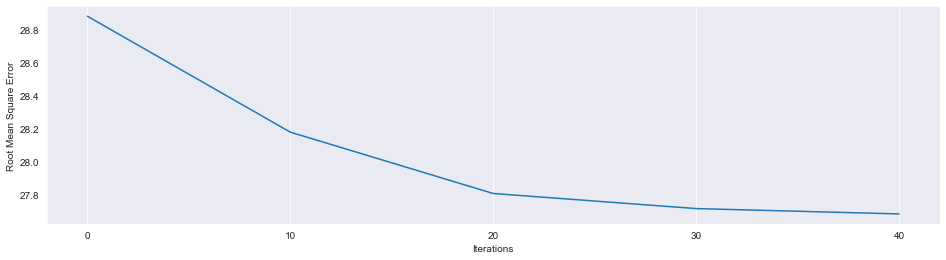

In [13]:
#Setting up prerequisites
#from numba import prange
#from mf import MF
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from cvxpy import *
from numpy import matrix
import time 
print("Setup Complete\n")



#Seeing the distribution of ratings given by the users
#print("See Overview of the Data")
p = df.groupby('rating')['rating'].agg(['count'])
# get movie count
movie_count = df.isnull().sum()[1]
# get customer count
cust_count = df['user_id'].nunique() - movie_count
# get rating count
rating_count = df['user_id'].count() - movie_count
# ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
# plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
# plt.axis('off')
# for i in range(1,6):
    # ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')










#Adding movie IDs to the dataset
# print("\nExtracting Movie IDs\n")
# movie_np = []
# movie_id = 0
# for x in range(df.shape[0]):
    # if(np.isnan(df.iloc[x]['rating'])):
        # movie_id = movie_id+1
    # movie_np = np.append(movie_np,movie_id)
# print(movie_np)
# print(len(movie_np))
# df['Movie_Id'] = movie_np.astype(int)
# print("Movie IDs extracted from the extra rows given")
# 
# 
# 
# 
# 
# 
# 
# 
#remove the extra Movie ID rows
# print("\nRemoving extra Movie ID rows\n")
# df = df[pd.notnull(df['Rating'])]
# df['Cust_Id'] = df['Cust_Id'].astype(int)
# print('-Dataset examples-')
# print(df.iloc[::100, :])
# print("\n\nThese are the final datatypes of the dataset")
# print(df.dtypes)
# 



#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='rating',index='user_id',columns='movie_id')
print(df_matrix.shape)



#Loading the Movie ID- Movie Title Mapping File
# print("\nLoading the Movie ID- Movie Title Mapping File\n")
# df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, 
# names = ['Movie_Id', 'Year', 'Name'])
# df_title.set_index('Movie_Id', inplace = True)
# print("See some Movie ID- Movie Title Mapping : \n")
# print (df_title.head(8))




print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())
a = time.time()
n_movies = movie_count
n_customers = cust_count
n_customers = 3
n_movies = 1009
print("\nNum of movies =", movie_count)
print("Num of users =", cust_count)
print()








#Choosing the number of latent attributes
n_attr= 100*1000000
#print(type(n_attr),type(n_movies), type(n_customers))
Q = Variable((n_attr,n_movies))
P = Variable((n_attr, n_customers))
acq_data = df_matrix.fillna(0.0)
print(acq_data.head())








R = np.array(acq_data)
R1= np.array(acq_data)


print("\nRandomly Distributing Test and Train Set by removing 20% values...\n")
#This cell works on Real DataSet
R = np.array(acq_data)
R1= np.array(acq_data)
#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)
#Randomly choose indices of the numpy array:
#print("Creating Random Indices\n")
# i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
# j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]
i = np.random.randint(0,R.shape[0],size=prop)
j = np.random.randint(0,R.shape[1],size=prop)
#print("Created Random Indices\n")
print("Done\n")
#print("i=",i)
#print("j=",j)
#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)
print("RMSE=",mse**0.5)
print("\nTraining ...\n")
mf = MF(R, K=2, alpha=0.01, beta=0.01, iterations=50)
training_process = mf.train()
L=np.rint(mf.full_matrix())
print("\nDone\n")
x = [x for x, y in training_process]
y = [y for x, y in training_process]
x = x[::10]
y = y[::10]
plt.figure(figsize=((16,4)))
plt.plot(x, np.sqrt(y))
plt.xticks(x, x)
print("Minimizing Error on Training Set:\n")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.grid(axis="y")
print("Learnt=\n",mf.full_matrix())
print("\nRating predictions=\n",L)
print()
print()
# print("Global bias:")
# print(mf.b)
# print()
# print("User bias:")
# print(mf.b_u)
# print()
# print("Item bias:")
# print(mf.b_i)
print("\nFinding Error on test set...\n")
msef=0.0
# for i1 in range(len(i)):
#     for i2 in range(len(j)):
#         if R1.item(i[i1],j[i2])!=0:
#             msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
# msef = (msef/(len(j)*len(i)))
valid_cmp = ~np.isnan(df_matrix)
msef = np.sum(np.sum(np.multiply(valid_cmp,np.square(R1-L)),axis=None))/(len(j)*len(i)*1.00)
b = time.time()
print("RMSE final=",msef**0.5)
print("Training time:",b-a,"s")

Setup Complete

(6040, 3706)


Data Cleaning Complete.
 See head of the Data Matrix:

movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5          NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   

movie_id  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
user_id                                                               
1          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4          NaN   Na

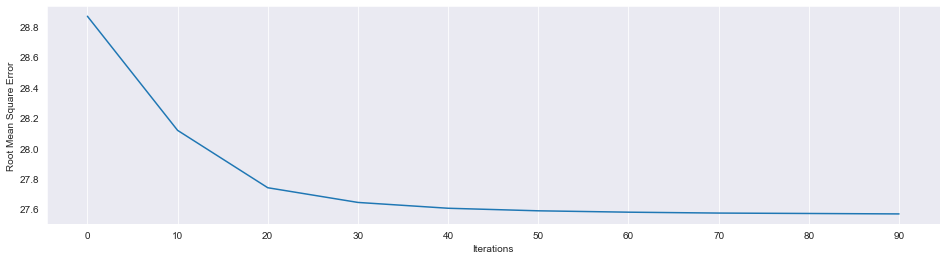

In [14]:
#Setting up prerequisites
#from numba import prange
#from mf import MF
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from cvxpy import *
from numpy import matrix
import time 
print("Setup Complete\n")



#Seeing the distribution of ratings given by the users
#print("See Overview of the Data")
p = df.groupby('rating')['rating'].agg(['count'])
# get movie count
movie_count = df.isnull().sum()[1]
# get customer count
cust_count = df['user_id'].nunique() - movie_count
# get rating count
rating_count = df['user_id'].count() - movie_count
# ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
# plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
# plt.axis('off')
# for i in range(1,6):
    # ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')










#Adding movie IDs to the dataset
# print("\nExtracting Movie IDs\n")
# movie_np = []
# movie_id = 0
# for x in range(df.shape[0]):
    # if(np.isnan(df.iloc[x]['rating'])):
        # movie_id = movie_id+1
    # movie_np = np.append(movie_np,movie_id)
# print(movie_np)
# print(len(movie_np))
# df['Movie_Id'] = movie_np.astype(int)
# print("Movie IDs extracted from the extra rows given")
# 
# 
# 
# 
# 
# 
# 
# 
#remove the extra Movie ID rows
# print("\nRemoving extra Movie ID rows\n")
# df = df[pd.notnull(df['Rating'])]
# df['Cust_Id'] = df['Cust_Id'].astype(int)
# print('-Dataset examples-')
# print(df.iloc[::100, :])
# print("\n\nThese are the final datatypes of the dataset")
# print(df.dtypes)
# 



#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='rating',index='user_id',columns='movie_id')
print(df_matrix.shape)



#Loading the Movie ID- Movie Title Mapping File
# print("\nLoading the Movie ID- Movie Title Mapping File\n")
# df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, 
# names = ['Movie_Id', 'Year', 'Name'])
# df_title.set_index('Movie_Id', inplace = True)
# print("See some Movie ID- Movie Title Mapping : \n")
# print (df_title.head(8))




print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())
a = time.time()
n_movies = movie_count
n_customers = cust_count
n_customers = 3
n_movies = 1009
print("\nNum of movies =", movie_count)
print("Num of users =", cust_count)
print()








#Choosing the number of latent attributes
n_attr= 100*1000000
#print(type(n_attr),type(n_movies), type(n_customers))
Q = Variable((n_attr,n_movies))
P = Variable((n_attr, n_customers))
acq_data = df_matrix.fillna(0.0)
print(acq_data.head())








R = np.array(acq_data)
R1= np.array(acq_data)


print("\nRandomly Distributing Test and Train Set by removing 20% values...\n")
#This cell works on Real DataSet
R = np.array(acq_data)
R1= np.array(acq_data)
#Set the number of values to replace. For example 20%:
prop = int(R.size * 0.2)
#Randomly choose indices of the numpy array:
#print("Creating Random Indices\n")
# i = [np.random.choice(range(R.shape[0])) for _ in range(prop)]
# j = [np.random.choice(range(R.shape[1])) for _ in range(prop)]
i = np.random.randint(0,R.shape[0],size=prop)
j = np.random.randint(0,R.shape[1],size=prop)
#print("Created Random Indices\n")
print("Done\n")
#print("i=",i)
#print("j=",j)
#Change values with 0
R[i,j] = 0
print("Original:\n",R1)
print("Test Set:\n",R)
R=np.rint(R)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R, R1)
print("RMSE=",mse**0.5)
print("\nTraining ...\n")
mf = MF(R, K=2, alpha=0.01, beta=0.01, iterations=100)
training_process = mf.train()
L=np.rint(mf.full_matrix())
print("\nDone\n")
x = [x for x, y in training_process]
y = [y for x, y in training_process]
x = x[::10]
y = y[::10]
plt.figure(figsize=((16,4)))
plt.plot(x, np.sqrt(y))
plt.xticks(x, x)
print("Minimizing Error on Training Set:\n")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.grid(axis="y")
print("Learnt=\n",mf.full_matrix())
print("\nRating predictions=\n",L)
print()
print()
# print("Global bias:")
# print(mf.b)
# print()
# print("User bias:")
# print(mf.b_u)
# print()
# print("Item bias:")
# print(mf.b_i)
print("\nFinding Error on test set...\n")
msef=0.0
# for i1 in range(len(i)):
#     for i2 in range(len(j)):
#         if R1.item(i[i1],j[i2])!=0:
#             msef = msef + (R1.item((i[i1],j[i2]))-(L).item((i[i1],j[i2])))**2
# msef = (msef/(len(j)*len(i)))
valid_cmp = ~np.isnan(df_matrix)
msef = np.sum(np.sum(np.multiply(valid_cmp,np.square(R1-L)),axis=None))/(len(j)*len(i)*1.00)
b = time.time()
print("RMSE final=",msef**0.5)
print("Training time:",b-a,"s")